# Pattern Recognition 2022-23 1st Lab: Speech Recognition with Hidden Markov Models and Recurrent Neural Networks<br>

Ηλιόπουλος Γεώργιος: 03118815 <br>
Σερλής Αναστάσιος Εμανουήλ - 03118125<br>
<br>

## Imports

In [1]:
#!pip install librosa
#!pip install pytorch

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Libraries

In [1]:
import torch
import librosa
import pandas
import numpy as np
import os
import matplotlib.pyplot as plt
from word2number import w2n
import re
import IPython.display as ipd
import sounddevice as sd
import pandas as pd
from sklearn.decomposition import PCA

C:\Users\grgsl\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Step 2 - Data Parser

In [4]:
digits_dir = "./digits"
n_samples=133

def data_parser(dir):
    wavs = [None] * n_samples
    speakers = np.zeros(n_samples, dtype=int)
    digits = np.zeros(n_samples, dtype=int)

    for i, file in enumerate(os.listdir(dir)):
         fl=os.fsdecode(file) #read file name
         wavs[i], _ = librosa.load(os.path.join(dir, fl), sr=16000) #librosa load
         temp_list = re.split(r'(^[^\d]+)',fl.split('.')[0] )[1:] # split word and speaker
         digits[i] = w2n.word_to_num(temp_list[0]) #get digit 
         speakers[i] = int(temp_list[1]) #get speaker

    return wavs, speakers, digits

wavs,speakers,digits = data_parser(digits_dir)
for i in range(10): #print wav sample, speaker and digit for 10 first files
    print("wav_file: {}\t speaker = {}\t digit = {}\t samples = {}".format(i+1,speakers[i],digits[i],wavs[i][:3]))

print("We have {} wav files for {} digits from {} different speakers."\
      .format(len(wavs), np.unique(digits).shape[0], np.unique(speakers).shape[0]))
#check sound on speaker 1 and diff digits
sd.play(wavs[0], 16000) #speaker 1 - digit 8
sd.play(wavs[14],16000) #speaker 1 - digit 5

wav_file: 1	 speaker = 1	 digit = 8	 samples = [-0.0007019  -0.00088501 -0.00048828]
wav_file: 2	 speaker = 10	 digit = 8	 samples = [ 9.1552734e-05 -3.0517578e-05 -2.7465820e-04]
wav_file: 3	 speaker = 11	 digit = 8	 samples = [-0.0010376  -0.00109863 -0.00112915]
wav_file: 4	 speaker = 12	 digit = 8	 samples = [1.2207031e-04 9.1552734e-05 3.0517578e-05]
wav_file: 5	 speaker = 13	 digit = 8	 samples = [-0.0005188  -0.00045776 -0.00064087]
wav_file: 6	 speaker = 14	 digit = 8	 samples = [-0.00045776 -0.00018311  0.00024414]
wav_file: 7	 speaker = 15	 digit = 8	 samples = [-0.00021362 -0.00015259  0.        ]
wav_file: 8	 speaker = 2	 digit = 8	 samples = [ 1.5258789e-04  2.1362305e-04 -3.0517578e-05]
wav_file: 9	 speaker = 3	 digit = 8	 samples = [0.00012207 0.0005188  0.00021362]
wav_file: 10	 speaker = 4	 digit = 8	 samples = [-0.00036621 -0.00048828 -0.00045776]
We have 133 wav files for 9 digits from 15 different speakers.


## Step 3 - Extract MFCCs

In [5]:
sr=16000 #wanted parameters for mfcc
feats=13
win_length=0.025
step=0.01

mfccs=[]
delta=[]
delta2=[]

for i in range(n_samples): #compute mfccs, delta (1st and 2nd order)
    mfcc_temp = librosa.feature.mfcc(wavs[i], sr=sr, n_mfcc=feats, hop_length=int(win_length*sr), n_fft=int(step*sr))
    mfccs.append(mfcc_temp)
    delta.append(librosa.feature.delta(mfcc_temp))
    delta2.append(librosa.feature.delta(mfcc_temp, order=2))



C:\Users\manos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


In [6]:
print("MFCCS  shape is {} with shape {}.".format(type(mfccs[0]),mfccs[0].shape))
print("delta  shape is {} with shape {}.".format(type(delta[0]),delta[0].shape))
print("delta2 shape is {} with shape {}.".format(type(delta2[0]),delta2[0].shape))

MFCCS  shape is <class 'numpy.ndarray'> with shape (13, 30).
delta  shape is <class 'numpy.ndarray'> with shape (13, 30).
delta2 shape is <class 'numpy.ndarray'> with shape (13, 30).


## Step 4 - Histograms of 1st and 2nd MFCCs

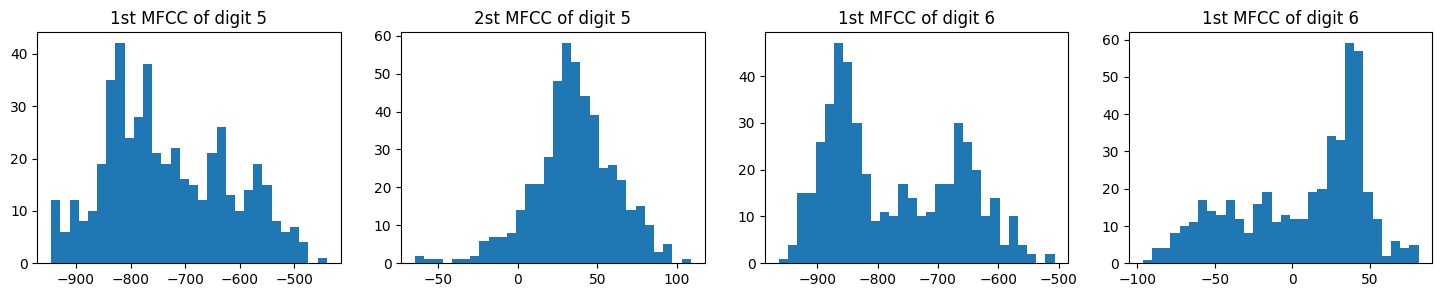

In [7]:
# AM1: 031 18 125 --> n1 = 5
# AM2: 031 18 815 --> n2 = 5 -> 6
n1=5
n2=6

# Extract 1st and 2nd mfcc of digit 5
mfcc1_n1 = [mfccs[i][0] for i in range(n_samples) if digits[i] == n1]
mfcc2_n1 = [mfccs[i][1] for i in range(n_samples) if digits[i] == n1]

# Extract 1st and 2nd mfcc of digit 6
mfcc1_n2 = [mfccs[i][0] for i in range(n_samples) if digits[i] == n2]
mfcc2_n2 = [mfccs[i][1] for i in range(n_samples) if digits[i] == n2]

#flattened lists
mfcc1_n1_fl=list(np.concatenate(mfcc1_n1).flat)
mfcc2_n1_fl=list(np.concatenate(mfcc2_n1).flat)
mfcc1_n2_fl=list(np.concatenate(mfcc1_n2).flat)
mfcc2_n2_fl=list(np.concatenate(mfcc2_n2).flat)


# Plot histograms
fig = plt.figure(figsize=(18,3))
ax1=fig.add_subplot(1, 4, 1)
plt.hist(mfcc1_n1_fl, bins=30)
ax1.title.set_text('1st MFCC of digit {}'.format(n1))
ax2=fig.add_subplot(1, 4, 2)
plt.hist(mfcc2_n1_fl, bins=30)
ax2.title.set_text('2st MFCC of digit {}'.format(n1))
ax3=fig.add_subplot(1, 4, 3)
plt.hist(mfcc1_n2_fl, bins=30)
ax3.title.set_text('1st MFCC of digit {}'.format(n2))
ax4=fig.add_subplot(1, 4, 4)
plt.hist(mfcc2_n2_fl, bins=30)
ax4.title.set_text('1st MFCC of digit {}'.format(n2))
plt.show()

In [8]:
#get 2 instances for each of the digits 5 and 6
speaker1=2
speaker2=14
index1_n1 = int(np.where((speakers == speaker1) & (digits == n1) )[0][0])
index2_n1 = int(np.where((speakers == speaker2) & (digits == n1) )[0][0])
index1_n2 = int(np.where((speakers == speaker1) & (digits == n2) )[0][0])
index2_n2 = int(np.where((speakers == speaker2) & (digits == n2) ) [0][0])

print('\033[1m' + "Samples selected for MFSC & MFCC correlation:" + '\033[0m')
print("Speaker={}\t digit={}\t index={}".format(speaker1,n1,index1_n1))
print("Speaker={}\t digit={}\t index={}".format(speaker1,n2,index1_n2))
print("Speaker={}\t digit={}\t index={}".format(speaker2,n1,index2_n1))
print("Speaker={}\t digit={}\t index={}".format(speaker2,n2,index2_n2))

#extract MFSCs for selected 4 samples
mfsc1_n1 = librosa.feature.melspectrogram(wavs[index1_n1], sr=sr, hop_length=int(win_length*sr), n_fft=int(step*sr), n_mels=feats)
mfsc1_n2 = librosa.feature.melspectrogram(wavs[index1_n2], sr=sr, hop_length=int(win_length*sr), n_fft=int(step*sr), n_mels=feats)
mfsc2_n1 = librosa.feature.melspectrogram(wavs[index2_n1], sr=sr, hop_length=int(win_length*sr), n_fft=int(step*sr), n_mels=feats)
mfsc2_n2 = librosa.feature.melspectrogram(wavs[index2_n2], sr=sr, hop_length=int(win_length*sr), n_fft=int(step*sr), n_mels=feats)


Samples selected for MFSC & MFCC correlation:
Speaker=2	 digit=5	 index=21
Speaker=2	 digit=6	 index=95
Speaker=14	 digit=5	 index=19
Speaker=14	 digit=6	 index=93


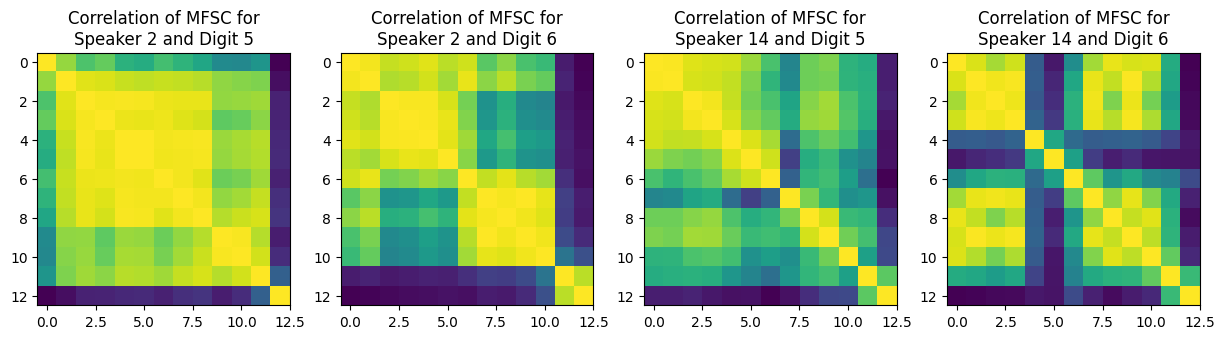

In [9]:
# plot correlation for MFSC for each instance
fig = plt.figure(figsize=(15,12))

#plt.title("HI\n")

ax1=fig.add_subplot(1, 4, 1)
ax1.title.set_text('Correlation of MFSC for\nSpeaker {} and Digit {}'.format(speaker1, n1))
plt.imshow((pd.DataFrame.from_records(mfsc1_n1.T)).corr())

ax3=fig.add_subplot(1, 4, 2)
ax3.title.set_text('Correlation of MFSC for\nSpeaker {} and Digit {}'.format(speaker1, n2))
plt.imshow((pd.DataFrame.from_records(mfsc1_n2.T)).corr())

ax5=fig.add_subplot(1, 4, 3)
ax5.title.set_text('Correlation of MFSC for\nSpeaker {} and Digit {}'.format(speaker2, n1))
plt.imshow((pd.DataFrame.from_records(mfsc2_n1.T)).corr())

ax7=fig.add_subplot(1, 4, 4)
ax7.title.set_text('Correlation of MFSC for\nSpeaker {} and Digit {}'.format(speaker2, n2))
plt.imshow((pd.DataFrame.from_records(mfsc2_n2.T)).corr())


plt.show()

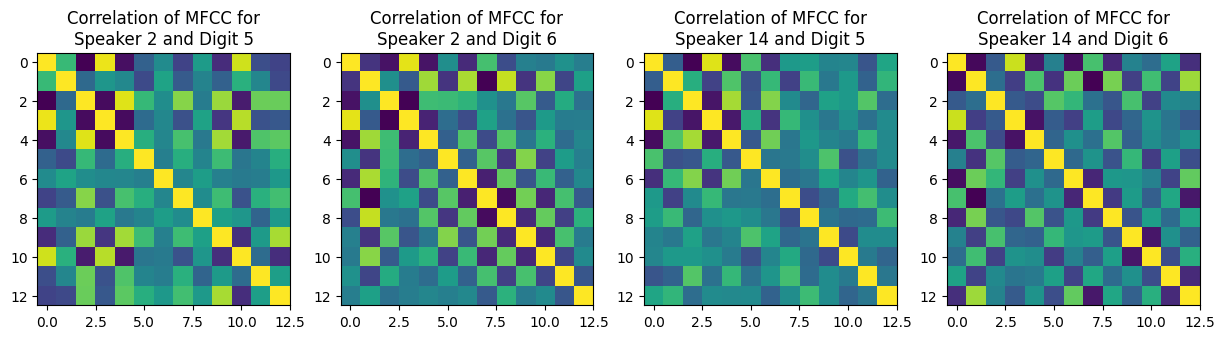

In [10]:
# plot correlation for MFCC for each instance
fig = plt.figure(figsize=(15,12))

ax1=fig.add_subplot(1, 4, 1)
ax1.title.set_text('Correlation of MFCC for\nSpeaker {} and Digit {}'.format(speaker1, n1))
plt.imshow((pd.DataFrame.from_records(mfccs[index1_n1].T)).corr())

ax2=fig.add_subplot(1, 4, 2)
ax2.title.set_text('Correlation of MFCC for\nSpeaker {} and Digit {}'.format(speaker1, n2))
plt.imshow((pd.DataFrame.from_records(mfccs[index1_n2].T)).corr())


ax3=fig.add_subplot(1, 4, 3)
ax3.title.set_text('Correlation of MFCC for\nSpeaker {} and Digit {}'.format(speaker2, n1))
plt.imshow((pd.DataFrame.from_records(mfccs[index2_n1].T)).corr())

ax4=fig.add_subplot(1, 4, 4)
ax4.title.set_text('Correlation of MFCC for\nSpeaker {} and Digit {}'.format(speaker2, n2))
plt.imshow((pd.DataFrame.from_records(mfccs[index2_n2].T)).corr())

plt.show()

## Step 5 - Feature Extraction

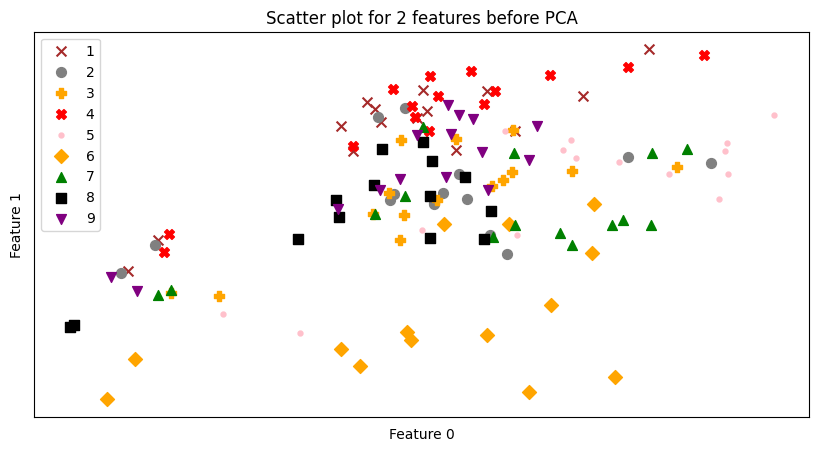

In [11]:
#get global feature extraction
# 133 rows which correspond to the total samples
# 6*13 columns which correspond to the mean values and variance for each one of the 13 different mfcc features

features = np.zeros((n_samples, 6*13))
for i in range(n_samples):
    features[i, :13] = np.mean(mfccs[i], axis=1)
    features[i, 13:26] = np.mean(delta[i], axis=1)
    features[i, 26:39] = np.mean(delta2[i], axis=1)
    features[i, 39:52] = np.std(mfccs[i], axis=1)
    features[i, 52:65] = np.std(delta[i], axis=1)
    features[i, 65:  ] = np.std(delta2[i], axis=1)

colors = ['orange', 'black', 'orange', 'pink', 'gray', 'green', 'purple', 'brown', 'red'] #set different colors
numbers=[i for i in range(1,10)] #set digit values
symbols = ['.', 'o', 'v', '^', 'x', 'D', "X", 's', 'P']


def scatter(feats, y, dims=2, PCA=1):
    if dims == 2: #in case of 2 feats
        #plt.rcParams['figure.figsize'] = [10, 5]
        fig, ax = plt.subplots()
        feat0 = feats[:, 0]
        feat1 = feats[:, 1]
        for i in range(9):
             ax.scatter(feat0[y == i+1], feat1[y == i+1], c=colors[i],
                    label=numbers[i], s=50, alpha=1,marker = symbols[i])
             ax.set_xlabel('Feature 0')
             ax.set_ylabel('Feature 1')
             if(PCA==0):
                 ax.title.set_text('Scatter plot for 2 features before PCA')
             if(PCA==1):
                 ax.title.set_text('Scatter plot for 2 features after PCA')
            
    if dims == 3: #in case of 3 feats
        plt.rcParams['figure.figsize'] = [7, 7]
        fig = plt.figure()
        ax = plt.axes(projection ="3d")
        feat0 = feats[:, 0]
        feat1 = feats[:, 1]
        feat2 = feats[:, 2]
        for i in range(9):
            ax.scatter(feat0[y == i+1], feat1[y == i+1], feat2[y == i+1], c=colors[i],
                    label=numbers[i], s=50, alpha=1,marker = symbols[i])
            ax.set_xlabel('Feature 0')
            ax.set_ylabel('Feature 1')
            ax.set_zlabel('Feature 2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend()
    plt.show()

plt.rcParams['figure.figsize'] = [10, 5]    
np.random.shuffle(colors)
np.random.shuffle(symbols)
scatter(features,digits,2,PCA=0)

## Step 6 - PCA

In [12]:
#set 2d and 3d PCAs

PCA_2D= PCA(n_components=2)
PCA_3D= PCA(n_components=3)

#reduce to two and three dims via PCA
feats_pca2d = PCA_2D.fit_transform(features)
feats_pca3d = PCA_3D.fit_transform(features)

# find varinace ratios
print("Variance ratio after 2D PCA is:",(PCA_2D.explained_variance_ratio_[0])*100,"%","and",(PCA_2D.explained_variance_ratio_[1])*100,"%")
print("Variance ratio after 3D PCA is:",(PCA_3D.explained_variance_ratio_[1])*100,"%","and",(PCA_3D.explained_variance_ratio_[1])*100,"%","and",(PCA_3D.explained_variance_ratio_[2])*100,"%")

Variance ratio after 2D PCA is: 67.38224671817895 % and 11.801490199101302 %
Variance ratio after 3D PCA is: 11.801490199101302 % and 11.801490199101302 % and 7.443867525850051 %


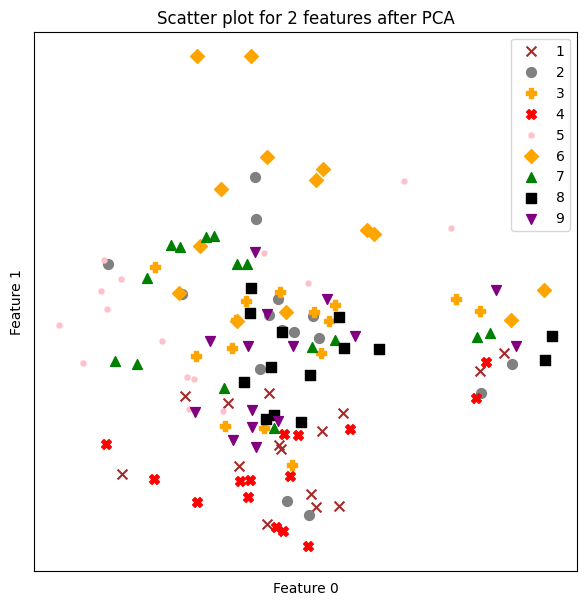

In [13]:
#scatter plot for 2d-pca
#np.random.shuffle(colors)
#np.random.shuffle(symbols)
plt.rcParams['figure.figsize'] = [7, 7] 
scatter(feats_pca2d,digits,2,PCA=1)

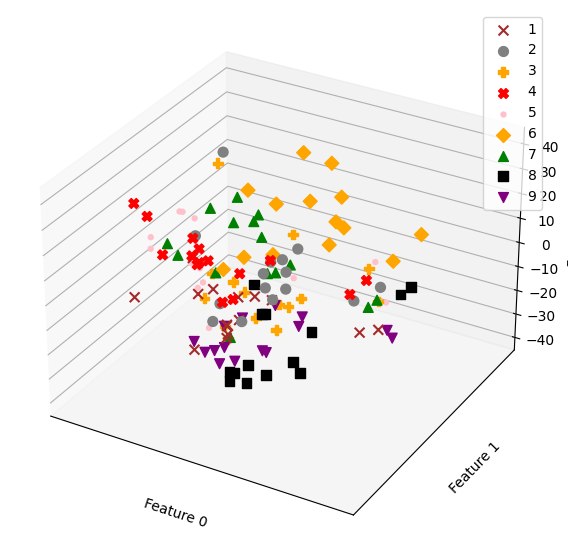

In [14]:
#scatter plot for 3d-pca
#np.random.shuffle(colors)
#np.random.shuffle(symbols)
scatter(feats_pca3d,digits,3,PCA=1)

In [15]:
print(PCA_2D.explained_variance_ratio_)
print(np.sum(PCA_2D.explained_variance_ratio_))
print(PCA_3D.explained_variance_ratio_)
print(np.sum(PCA_3D.explained_variance_ratio_))

[0.67382247 0.1180149 ]
0.7918373691728026
[0.67382247 0.1180149  0.07443868]
0.8662760444313031


In [16]:
pcas = []
max_d = 15
var = []

for i in range(max_d):
    pca_iD = PCA(n_components = i)
    pca_iD.fit_transform(features)
    var.append(np.sum(pca_iD.explained_variance_ratio_)*100)

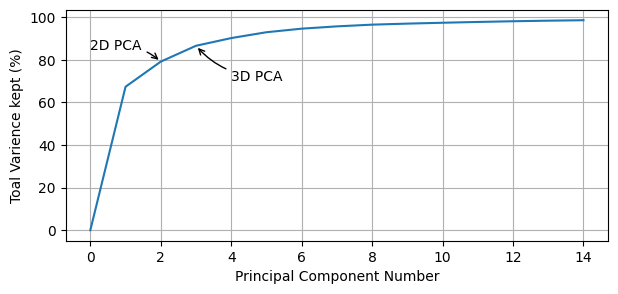

In [17]:
fig=plt.figure(figsize=(7,3))
plt.plot(range(max_d), var)
plt.ylabel("Toal Varience kept (%)")
plt.xlabel("Principal Component Number")
plt.annotate('2D PCA',xy=(2,79.18),arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.2'),xytext=(0,85))
plt.annotate('3D PCA',xy=(3,86.627),arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.2'),xytext=(4,70))
plt.grid()

## Step 7 - Classification

In [2]:
# sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
from scipy.stats import multivariate_normal as mn

In [20]:
#importing Custom Naive Bayes Classifier from 1st lab with a few changes
class CustomNBClassifier(BaseEstimator, ClassifierMixin):  
    """Classify samples based on the Gaussian Naive Bayes"""

    def __init__(self):
        self.X_mean_ = None
        self.X_var_ = None
        self.prior = None
        self.classes = None
        self.n_classes = None


    def fit(self, X, y):
        """
        This should fit classifier. All the "work" should be done here.
        
        Calculates self.X_mean_ and self.X_var_ based on the mean 
        feature values in X for each class. Also, calculates self.prior
        that contains the prior probability of each class.
        
        self.X_mean_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.X_var_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.prior becomes a numpy.array of shape 
        (n_classes)
        
        fit always returns self.
        """

        # Initialize useful variables
        self.classes = np.unique(y)
        train_size, n_features = X.shape
        self.n_classes = len(self.classes)
        self.X_mean_ = np.zeros((self.n_classes, n_features))
        self.X_var_ = np.zeros((self.n_classes, n_features))

        # Compute mean and variance values for each class
        for count, value in enumerate(self.classes):
            idx_i = [i for i in range(train_size) if y[i] == value]
            X_i = np.take(X, idx_i, axis=0)
            self.X_mean_[count, :] = np.mean(X_i, axis=0, keepdims=True)
            self.X_var_[count, :] = np.var(X_i, axis=0, keepdims=True)
        
        # Compute prior probabilities for each class
        self.prior = np.zeros(self.n_classes)
        for i, value in enumerate(self.classes):
            self.prior[i] = np.count_nonzero(y == value) / train_size
        return self
        

    def predict(self, X):
        """
        Make predictions for X based on
        the highest posterior probability
        """

        # Compute likelihood
        like = np.zeros((self.n_classes, len(X)))
        for i in range(self.n_classes):
            like[i] = np.prod(1/(np.sqrt(2*np.pi*self.X_var_[i]+ 10**(-9))) * \
                      np.exp(-0.5*((X - self.X_mean_[i])**2 / (self.X_var_[i] + 10**(-9)))) \
                      , axis=1)

        return np.argmax(like.T * self.prior, axis=1) + 1
    
    def score(self, X, y): #returns accuracy
        """
        Return accuracy score on the predictions
        for X based on ground truth y
        """
        count = 0
        y_pred = self.predict(X)
        for i in range(len(y)):
            if y[i] == y_pred[i]:
                count += 1
        acc = count / len(y)
        return acc

In [21]:
#splitting data in test and train sets
X_train, X_test, y_train, y_test = train_test_split(features, digits, test_size=0.3, random_state=42, stratify=digits)

#normalizing data
X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

In [22]:
def score_print(classifier):
    cl = classifier
    print('\033[1m' + cl.__class__.__name__ + '\033[0m')
    cl.fit(X_train, y_train)
    a = cl.score(X_test, y_test)
    print("Normalized Data: {},\taccuracy: {}".format("no", a))
    cl = classifier
    cl.fit(X_train_norm, y_train)
    a = cl.score(X_test_norm, y_test)
    print("Normalized Data: {},\taccuracy: {}".format("yes", a))
    print()

In [23]:
score_print(CustomNBClassifier())
score_print(GaussianNB())
score_print(KNeighborsClassifier(n_neighbors=3))
score_print(LogisticRegression())
score_print(SVC(kernel="linear", probability=True))

CustomNBClassifier
Normalized Data: no,	accuracy: 0.625
Normalized Data: yes,	accuracy: 0.575

GaussianNB
Normalized Data: no,	accuracy: 0.625
Normalized Data: yes,	accuracy: 0.575

KNeighborsClassifier
Normalized Data: no,	accuracy: 0.525
Normalized Data: yes,	accuracy: 0.525

LogisticRegression
Normalized Data: no,	accuracy: 0.75
Normalized Data: yes,	accuracy: 0.175

SVC
Normalized Data: no,	accuracy: 0.75
Normalized Data: yes,	accuracy: 0.175



C:\Users\manos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Step 8 - Pytorch

In [4]:
# pytorch
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch import optim

In [5]:
#generating our data
f = 40
T = 1/f
step = 0.001
X = np.zeros((1500, 10))
y = np.zeros((1500, 10))

for i in range(len(X)):
    A = np.random.rand() #getting a random amplitude (0,1)
    start = np.random.rand() * (T) #getting a random starting point
    time = np.linspace(start, start+step*10, num=10)
    X[i] = A*np.sin(2*np.pi*f*time)
    y[i] =  A*np.cos(2*np.pi*f*time)

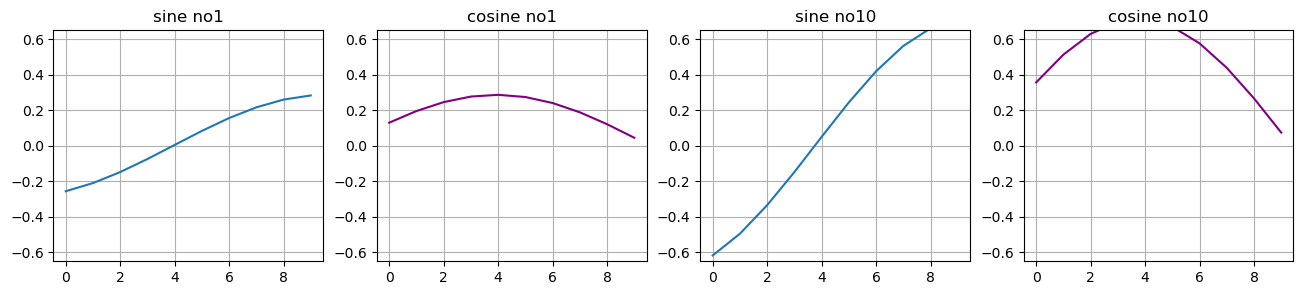

In [6]:
# plotting some of the data
fig = plt.figure(figsize=(16,3))

plt.subplot(1,4,1)
plt.plot(range(10), X[1])
plt.title("sine no1")
plt.ylim([-0.65, 0.65])
plt.grid()

plt.subplot(1,4,2)
plt.plot(range(10), y[1], color ="purple")
plt.title("cosine no1")
plt.ylim([-0.65, 0.65])
plt.grid()

plt.subplot(1,4,3)
plt.plot(range(10), X[10])
plt.title("sine no10")
plt.ylim([-0.65, 0.65])
plt.grid()

plt.subplot(1,4,4)
plt.plot(range(10), y[10], color ="purple")
plt.title("cosine no10")
plt.ylim([-0.65, 0.65])
plt.grid()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [8]:
# Defining a LSTM model
class LSTMNet(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTMCell(1, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), self.hidden_layer_size, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.hidden_layer_size, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [9]:
# model parameters
model = LSTMNet().double()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
#Training
train_losses = []
test_losses = []

#epochs = 1500
epochs = 1500
for i in range(epochs):
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    if i%100 == 0:
        print("Epoch:\t{}".format(i), end='\t')
        print('Train loss', loss.item(),end='\t')
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    with torch.no_grad():
        pred = model(X_test)
        loss = criterion(pred, y_test)
        if i%100 == 0:
            print('Test loss:', loss.item())
        test_losses.append(loss.item())

Epoch:	0	Train loss 0.1764446326047366	Test loss: 0.17297936664395158
Epoch:	100	Train loss 0.07351511604998519	Test loss: 0.071723786389132
Epoch:	200	Train loss 0.047745981416291404	Test loss: 0.04663149435009743
Epoch:	300	Train loss 0.034268964876932415	Test loss: 0.03305256200750073
Epoch:	400	Train loss 0.02875422646265995	Test loss: 0.027744338899301134
Epoch:	500	Train loss 0.025210900802712776	Test loss: 0.024326564616487127
Epoch:	600	Train loss 0.022480711070133545	Test loss: 0.021677881480159877
Epoch:	700	Train loss 0.020099275697565103	Test loss: 0.01939625166229177
Epoch:	800	Train loss 0.018422711132104762	Test loss: 0.01774951041654619
Epoch:	900	Train loss 0.01742006923425137	Test loss: 0.016781546878615293
Epoch:	1000	Train loss 0.01702089789290616	Test loss: 0.016393628738027684
Epoch:	1100	Train loss 0.01689464972441259	Test loss: 0.01626792154977686
Epoch:	1200	Train loss 0.016861397966180098	Test loss: 0.01623336063884903
Epoch:	1300	Train loss 0.0168519037009075

(1500,)


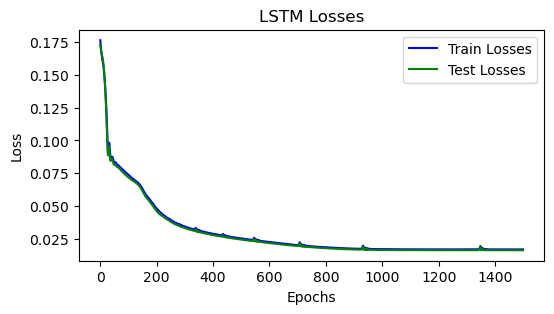

In [11]:
#plot LSTM losses
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
print(np.shape(train_losses))
plt.plot(np.arange(np.shape(train_losses)[0]),train_losses,label='Train Losses',color='b')
plt.plot(np.arange(np.shape(test_losses)[0]),test_losses,label='Test Losses',color='g')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Losses')
plt.show()

Text(0.5, 1.0, 'LSTM Test No.4')

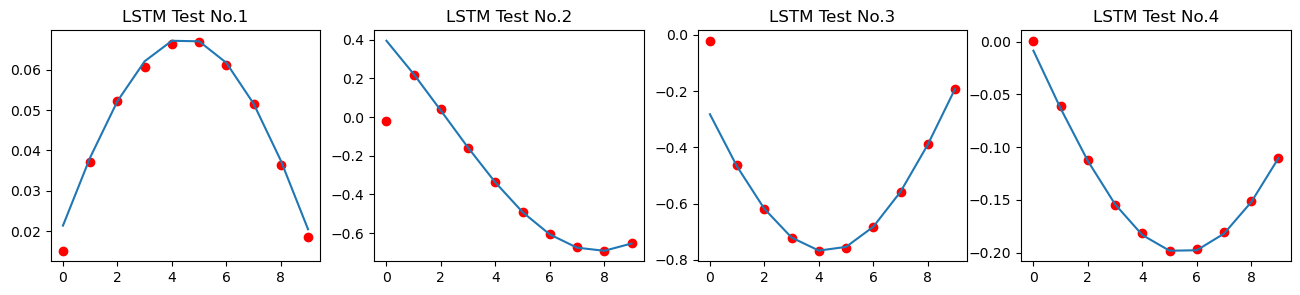

In [12]:
#comparison to ground truth values
outputs_LSTM = model.forward(X_test[:4, :]).detach().numpy()

# plotting some of the data
fig = plt.figure(figsize=(16,3))

plt.subplot(1,4,1)
plt.plot(range(10), y_test[0])
plt.scatter(range(10),outputs_LSTM[0],color='red')
plt.title("LSTM Test No.1")

plt.subplot(1,4,2)
plt.plot(range(10), y_test[1])
plt.scatter(range(10),outputs_LSTM[1],color='red')
plt.title("LSTM Test No.2")

plt.subplot(1,4,3)
plt.plot(range(10), y_test[2])
plt.scatter(range(10),outputs_LSTM[2],color='red')
plt.title("LSTM Test No.3")

plt.subplot(1,4,4)
plt.plot(range(10), y_test[3])
plt.scatter(range(10),outputs_LSTM[3],color='red')
plt.title("LSTM Test No.4")

## Step 9 - Free Spoken Digit Dataset (FSDD) - read, normalization, MFCCs and split

In [13]:
from glob import glob
import librosa as l
import os
from sklearn.preprocessing import StandardScaler
%pip install tqdm
import itertools
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score
from tqdm import tqdm

Note: you may need to restart the kernel to use updated packages.


Parser function was given to us to read and extract features from FSDD.

In [14]:
def parse_free_digits(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, "*.wav"))
    fnames = [f.split("\\")[1].split(".")[0].split("_") for f in files]
    ids = [f[2] for f in fnames]
    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = librosa.core.load(files[0], sr=None)

    def read_wav(f):
        wav, _ = librosa.core.load(f, sr=None)

        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Print dataset info
    print("Total wavs: {}. Fs = {} Hz".format(len(wavs), Fs))

    return wavs, Fs, ids, y, speakers


def extract_features(wavs, n_mfcc=6, Fs=8000):
    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [
        librosa.feature.mfcc(
            wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=n_mfcc
        ).T

        for wav in tqdm(wavs, desc="Extracting mfcc features...")
    ]

    print("Feature extraction completed with {} mfccs per frame".format(n_mfcc))

    return frames


def split_free_digits(frames, ids, speakers, labels):
    print("Splitting in train test split using the default dataset split")
    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ["0", "1", "2", "3", "4"]

    for idx, frame, label, spk in zip(ids, frames, labels, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test


def make_scale_fn(X_train):
    # Standardize on train data
    scaler = StandardScaler()
    scaler.fit(np.concatenate(X_train))
    print("Normalization will be performed using mean: {}".format(scaler.mean_))
    print("Normalization will be performed using std: {}".format(scaler.scale_))
    def scale(X):
        scaled = []

        for frames in X:
            scaled.append(scaler.transform(frames))
        return scaled
    return scale


def parser(directory, n_mfcc=6):
    wavs, Fs, ids, y, speakers = parse_free_digits(directory)
    frames = extract_features(wavs, n_mfcc=n_mfcc, Fs=Fs)
    X_train, X_test, y_train, y_test, spk_train, spk_test = split_free_digits(
        frames, ids, speakers, y
    )

    return X_train, X_test, y_train, y_test, spk_train, spk_test

Importing the data and extracting mfccs.

In [19]:
data_dir = './recordings'
X_train, X_test, y_train, y_test, spk_train, spk_test = parser(data_dir)

Total wavs: 3000. Fs = 8000 Hz


Extracting mfcc features...: 100%|████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 476.78it/s]

Feature extraction completed with 6 mfccs per frame
Splitting in train test split using the default dataset split


Splitting into training and validation set (80% - 20%). Then we normalize the data.

In [20]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print("If using all data to calculate normalization statistics")
scale_fn = make_scale_fn(X_train + X_dev + X_test)

print("If using X_train + X_dev to calculate normalization statistics")
scale_fn = make_scale_fn(X_train + X_dev)

print("If using X_train to calculate normalization statistics")
scale_fn = make_scale_fn(X_train)

X_train = scale_fn(X_train)
X_dev = scale_fn(X_dev)
X_test = scale_fn(X_test)

If using all data to calculate normalization statistics
Normalization will be performed using mean: [-517.82970054   62.38579546   18.81777177    9.58994409  -19.21332917
  -10.9054417 ]
Normalization will be performed using std: [152.29960089  51.98705826  36.71929108  29.63888661  24.80403285
  23.39483934]
If using X_train + X_dev to calculate normalization statistics
Normalization will be performed using mean: [-517.77180291   62.41689967   18.86552788    9.61652008  -19.17346573
  -10.77057824]
Normalization will be performed using std: [152.46343541  51.98376558  36.72489087  29.65300819  24.84129999
  23.30360999]
If using X_train to calculate normalization statistics
Normalization will be performed using mean: [-518.26792404   62.6955982    19.02111712    9.2949513   -19.08273599
  -10.69937107]
Normalization will be performed using std: [152.22819178  52.00177857  36.77214563  29.78257506  24.85783329
  23.20453466]


In [21]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

what_is_it is a function to see info about our data.

In [11]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def what_is_it (data):
    y = namestr(data, globals())
    print('\033[1m' + y[0] + ':\033[0m')
    print("Type of data:\t\t {}".format(type(data)))
    print("Length of data:\t\t {}".format(len(data)))
    print()
    print("Each element of {} has:\ntype:\t\t\t {}".format(y[0], type(data[0])))
    if type(data[0]) == np.ndarray:
        print("example shape:\t\t {}".format(data[0].shape))
        print("shape of [0][0]:\t {}".format(data[0][0].shape))
    print()

In [12]:
what_is_it(X_train)
what_is_it(X_test)
what_is_it(X_dev)
what_is_it(y_train)
what_is_it(y_test)
what_is_it(y_dev)
what_is_it(spk_train)
what_is_it(spk_test)

X_train:
Type of data:		 <class 'list'>
Length of data:		 1728

Each element of X_train has:
type:			 <class 'numpy.ndarray'>
example shape:		 (21, 6)
shape of [0][0]:	 (6,)

X_test:
Type of data:		 <class 'list'>
Length of data:		 300

Each element of X_test has:
type:			 <class 'numpy.ndarray'>
example shape:		 (20, 6)
shape of [0][0]:	 (6,)

X_dev:
Type of data:		 <class 'list'>
Length of data:		 432

Each element of X_dev has:
type:			 <class 'numpy.ndarray'>
example shape:		 (38, 6)
shape of [0][0]:	 (6,)

y_train:
Type of data:		 <class 'list'>
Length of data:		 1728

Each element of y_train has:
type:			 <class 'int'>

y_test:
Type of data:		 <class 'list'>
Length of data:		 300

Each element of y_test has:
type:			 <class 'int'>

y_dev:
Type of data:		 <class 'list'>
Length of data:		 432

Each element of y_dev has:
type:			 <class 'int'>

spk_train:
Type of data:		 <class 'list'>
Length of data:		 2700

Each element of spk_train has:
type:			 <class 'str'>

spk_test:
Type of d

In [13]:
print("Train size:\t\t{}".format(len(X_train)))
print("Validation size:\t{}".format(len(X_dev)))
print("Test size:\t\t{}".format(len(X_test)))

Train size:		1728
Validation size:	432
Test size:		300


According to the above and by studying the ready fuctions given to us we underastand that each sample is a 2d NumPy array that each row represents a frame and each collumn represents a MFCC.

## Step 10 - GMM-HMM

In [26]:
from pomegranate import *

Defining a list to keep the samples categorized by digit for the train set.

In [27]:
digit_pos_train = []

for digit in range(10):  
    digit_pos_train.append(digit)
    digit_pos_train[digit] = []
    for i in range(len(X_train)):
        if y_train[i] == digit:
            digit_pos_train[digit].append(i)

X_train_per_digit = []
for i in range(10):
    a = np.take(X_train, digit_pos_train[i], axis=0)
    X_train_per_digit.append(np.take(X_train, digit_pos_train[i], axis=0))

C:\Users\grgsl\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Defining a list to keep the samples categorized by digit for the validation set.

In [28]:
digit_pos_dev = []

for digit in range(10):  
    digit_pos_dev.append(digit)
    digit_pos_dev[digit] = []
    for i in range(len(X_dev)):
        if y_dev[i] == digit:
            digit_pos_dev[digit].append(i)

X_dev_per_digit = []
for i in range(10):
    a = np.take(X_dev, digit_pos_dev[i], axis=0)
    X_dev_per_digit.append(np.take(X_dev, digit_pos_dev[i], axis=0))

Defining the model nad the training function.

In [29]:
def train_GMM_HMM (X, n_states = 2, n_mixtures = 2, gmm = True, max_iterations = 30):

    # X is the data from a single digit (can be a numpy array)
    # n_states is the number of HMM states
    # n_mixtures is the number of Gaussians
    # gmm defines whether to use GMM or plain Gaussian

    dists = [] # list of probability distributions for the HMM states

    # GMM or plain Gaussian
    for i in range(n_states):
        if gmm and n_mixtures > 1:
            a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, n_mixtures, (np.vstack(X)).astype('float64'))
            # we use "np.vstack(X)" to stack all all frames in a single array
        else:
            a = MultivariateGaussianDistribution.from_samples((np.vstack(X)).astype('float64'))
        dists.append(a)

    # building the transition matrix
    trans_mat = np.zeros((n_states, n_states)) # transition matrix all zeros except the below "if"s
    for i in range(n_states):
        for j in range(n_states):
            if i == j or j == i+1:
                trans_mat[i, j] = 0.5 # setting aij = 0.5 if j = i+1 or i = j (transitions only between succesive states)

    starts = numpy.zeros(n_states) # your starting probability matrix
    starts[0] = 1

    ends = np.zeros(n_states) # your ending probability matrix
    ends[-1] = 1

    data = X # your data: must be a Python list that contains: 2D lists with the sequences (so its dimension would be num_sequences x seq_length x feature_dimension)
              # But be careful, it is not a numpy array, it is a Python list (so each sequence can have different length)

    # Define the GMM-HMM
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(i) for i in range(n_states)])
    
    max_iter = max_iterations
    # Fit the model
    model.fit(X, max_iterations = max_iter)
    
    return model

## Step 11 - Training the models

Making the models (10), one for each digit.

In [30]:
models = []
for i in range(10):
    models.append(train_GMM_HMM((X_train_per_digit[i]), n_states = 4, n_mixtures = 4))

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


## Step 12 - Testing the models

Function that finds the predictions based on the calculation of the log likelihood for each recording of the validation set.

In [31]:
def predictions(models, X):
    
    preds = np.zeros(len(X), dtype='int') # predictions
    
    for i in range(len(X)):
        logs = np.zeros(10)
        
        for j in range(10):
            logp, _ = models[j].viterbi(X[i]) # Calculation of the log likelihood for each recording with viterbi algorithm
            logs[j] = logp # Saving the log likelihood for each model
        preds[i] = np.argmax(logs) # Selecting the max log likelihood
    
    return preds

In [71]:
preds = predictions(models, X_dev)
print("The predicttions for the first 10 samples are: {}\nwhile the real values are:{}".format(preds[0:10], y_dev[0:10]))

The predicttions for the first 10 samples are: [5 4 9 2 3 3 0 5 0 9]
while the real values are:[5, 4, 5, 2, 3, 3, 0, 5, 0, 9]


Function that returns the accuracy of a model.

In [33]:
def accuracy (predictions, labels):
    count = 0
    for i in range(len(labels)):
        if predictions[i] == labels[i]:
            count = count + 1
    return count/len(labels)

In [73]:
acc = accuracy(predictions(models, X_dev), y_dev)
print("Validation set:")
print("The accuracy of the model is {:.3f}.".format(acc))
print("this model has 2 HMM states and 2 GMMs.")

Validation set:
The accuracy of the model is 0.903.
this model has 2 HMM states and 2 GMMs.


In [35]:
acc = accuracy(predictions(models, X_test), y_test)
print("Test set:")
print("The accuracy of the model is {:.3f}.".format(acc))
print("this model has 2 HMM states and 2 GMMs.")

Test set:
The accuracy of the model is 0.510.
this model has 2 HMM states and 2 GMMs.


Getting experimntal with the parameters of the model to select the best combination.

In [75]:
from IPython.display import clear_output

In [76]:
states = [1, 2, 3 ,4]
GMMs= [1, 2, 3, 4, 5]

accuracies = []

for state in states:
    for gmm in GMMs:
        models = []
        print("...currently running model with {} HMM states and {} Gaussian distirbutions...".format(state, gmm))
        for i in range(10):
            models.append(train_GMM_HMM(X_train_per_digit[i], n_states = state, n_mixtures = gmm))
        acc = accuracy(predictions(models, X_dev), y_dev) # accuracy from validation set to avoid overfitting
        accuracies.append([acc, state, gmm])

...currently running model with 1 HMM states and 1 Gaussian distirbutions...
...currently running model with 1 HMM states and 2 Gaussian distirbutions...
...currently running model with 1 HMM states and 3 Gaussian distirbutions...
...currently running model with 1 HMM states and 4 Gaussian distirbutions...


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


...currently running model with 1 HMM states and 5 Gaussian distirbutions...
...currently running model with 2 HMM states and 1 Gaussian distirbutions...
...currently running model with 2 HMM states and 2 Gaussian distirbutions...
...currently running model with 2 HMM states and 3 Gaussian distirbutions...


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


...currently running model with 2 HMM states and 4 Gaussian distirbutions...


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


...currently running model with 2 HMM states and 5 Gaussian distirbutions...


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


...currently running model with 3 HMM states and 1 Gaussian distirbutions...
...currently running model with 3 HMM states and 2 Gaussian distirbutions...
...currently running model with 3 HMM states and 3 Gaussian distirbutions...


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


...currently running model with 3 HMM states and 4 Gaussian distirbutions...


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


...currently running model with 3 HMM states and 5 Gaussian distirbutions...


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


...currently running model with 4 HMM states and 1 Gaussian distirbutions...
...currently running model with 4 HMM states and 2 Gaussian distirbutions...
...currently running model with 4 HMM states and 3 Gaussian distirbutions...


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


...currently running model with 4 HMM states and 4 Gaussian distirbutions...


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


...currently running model with 4 HMM states and 5 Gaussian distirbutions...


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


In [77]:
accuracies

[[0.30092592592592593, 1, 1],
 [0.35648148148148145, 1, 2],
 [0.2986111111111111, 1, 3],
 [0.33564814814814814, 1, 4],
 [0.3263888888888889, 1, 5],
 [0.2800925925925926, 2, 1],
 [0.35648148148148145, 2, 2],
 [0.4166666666666667, 2, 3],
 [0.4027777777777778, 2, 4],
 [0.4166666666666667, 2, 5],
 [0.32175925925925924, 3, 1],
 [0.47685185185185186, 3, 2],
 [0.46064814814814814, 3, 3],
 [0.4699074074074074, 3, 4],
 [0.4791666666666667, 3, 5],
 [0.3425925925925926, 4, 1],
 [0.4675925925925926, 4, 2],
 [0.49074074074074076, 4, 3],
 [0.5115740740740741, 4, 4],
 [0.5532407407407407, 4, 5]]

In [98]:
for i in range(len(accuracies)):
    print("{:.4f}".format(accuracies[i][0]))

0.3009
0.3565
0.2986
0.3356
0.3264
0.2801
0.3565
0.4167
0.4028
0.4167
0.3218
0.4769
0.4606
0.4699
0.4792
0.3426
0.4676
0.4907
0.5116
0.5532


In each element of the list "accuracies" the first is the accuracy the second the number of states and the third one the number of gaussian distirbutions.

In [80]:
acc = []
hmm_states = []
gmm_dist = []
max_acc = 0

for accu in accuracies:
    acc.append(accu[0])
    hmm_states.append(accu[1])
    gmm_dist.append(accu[2])
    if accu[0] > max_acc:
        max_acc = accu[0]
        max_hmm = accu[1]
        max_gmm = accu[2]

In [81]:
print("The best accuracy we have achieved is {:.3f} while using models with {} HMM states and {} Gaussian Distirbutions.".format(max_acc, max_hmm, max_gmm))

The best accuracy we have achieved is 0.553 while using models with 4 HMM states and 5 Gaussian Distirbutions.


In [82]:
k = 0
shape = (len(states), len(GMMs))
plot_acc = np.empty(shape)

for i in range(len(states)):
    for z in range(len(GMMs)):
        plot_acc[i][z] = acc[k]
        k = k + 1

In [83]:
X = states
Y = GMMs
Z = plot_acc

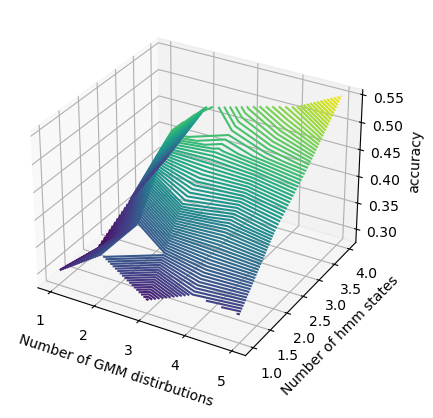

In [84]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(Y, X, Z, 100)
ax.set_xlabel('Number of GMM distirbutions')
ax.set_ylabel('Number of hmm states')
ax.set_zlabel('accuracy');

## Step 13 - Confusion Matrix

In [85]:
print('max_hmm = {}'.format(max_hmm))
print('max_gmm = {}'.format(max_gmm))

max_hmm = 4
max_gmm = 5


Making the models with {{ max_hmm }} HMM states and {{ max_gmm }} Gaussian Distirbutions.

In [86]:
models = []
for i in range(10):
    models.append(train_GMM_HMM(X_train_per_digit[i], n_states = max_hmm, n_mixtures = max_gmm))

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate\bayes.pyx", line 815, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate\distributions\MultivariateGaussianDistribution.pyx", line 269, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions._UFuncOutputCastingError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


plot_confusion_matrix is a function that allows us to plot the Confusion Matrix.

In [87]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Saving the predictions for our models and calculating the elements of the confusion matrix.

Confusion Matrix for validation set.

In [88]:
preds = predictions(models, X_dev)

Confusion_Matrix = np.zeros((10,10))

for sample in range(len(preds)):
    Confusion_Matrix[y_dev[sample], preds[sample]] += 1
    
Confusion_Matrix = Confusion_Matrix.astype(int)

The accuracy for the validation set is 0.523.
Confusion matrix, without normalization
[[26  3  6  1  2  0  0  0  0  5]
 [ 7 18  1  1  3  5  0  1  2  5]
 [ 1  0 18 10  2  3  0  4  2  3]
 [ 0  4  7 20  1  1  4  4  1  2]
 [ 5  1  2  2 20 11  0  2  0  0]
 [ 1  0  0  0  9 30  1  0  0  2]
 [ 1  3  2  6  2  3 17  3  6  1]
 [ 1  3  3  1  2  1  4 24  4  0]
 [ 0  0  8  3  3  3  3  0 22  1]
 [ 2  2  1  1  2  4  0  0  0 31]]


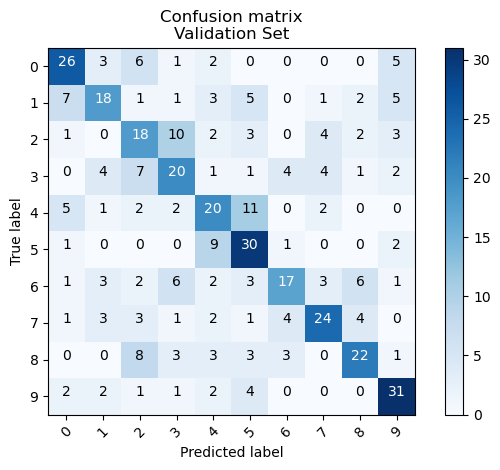

In [89]:
print("The accuracy for the validation set is {:.3f}.".format(accuracy(predictions(models, X_dev), y_dev)))
plot_confusion_matrix(Confusion_Matrix, classes = np.unique(y_dev), normalize=False, title='Confusion matrix\nValidation Set', cmap=plt.cm.Blues)

Confusion Matrix for test set.

In [90]:
preds = predictions(models, X_test)

Confusion_Matrix = np.zeros((10,10))

for sample in range(len(preds)):
    Confusion_Matrix[y_test[sample], preds[sample]] += 1
    
Confusion_Matrix = Confusion_Matrix.astype(int)

The accuracy for the test set is 0.507.
Confusion matrix, without normalization
[[20  1  4  0  1  0  1  0  0  3]
 [ 7 11  1  0  2  2  0  1  2  4]
 [ 0  2 19  5  0  0  1  1  0  2]
 [ 3  0  6 18  0  0  1  2  0  0]
 [ 4  1  1  0 13 10  0  0  1  0]
 [ 0  2  1  0  5 15  0  0  2  5]
 [ 0  2  4  3  0  5 11  2  3  0]
 [ 2  3  3  2  0  1  1 14  3  1]
 [ 0  0  4  4  3  1  2  1 11  4]
 [ 2  1  1  1  2  2  0  1  0 20]]


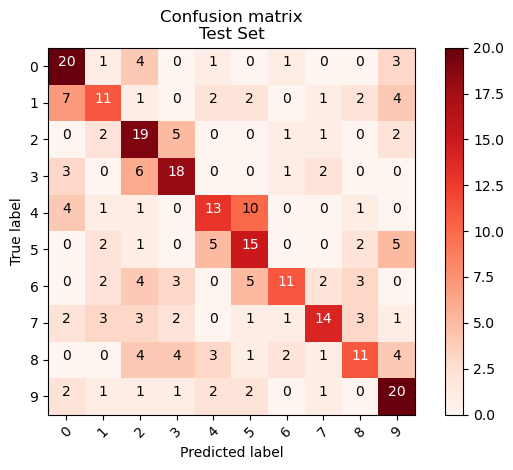

In [91]:
print("The accuracy for the test set is {:.3f}.".format(accuracy(predictions(models, X_test), y_test)))
plot_confusion_matrix(Confusion_Matrix, classes = np.unique(y_test), normalize=False, title='Confusion matrix\nTest Set', cmap=plt.cm.Reds)

### Βήμα 14 - LSTM Models

In [41]:
#code from lstm.py
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn


class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        self.lengths = [len(instance) for instance in feats] # Find the lengths 

        self.feats = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('int64')

    def zero_pad_and_stack(self, x):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        padded = []
        # --------------- Insert your code here ---------------- #
        padded=([np.pad(instance, ((0, np.max(self.lengths)-len(instance)), (0, 0))) for instance in x])
        return np.array(padded)

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]

    def __len__(self):
        return len(self.feats)

In [42]:
# define parameters, dataset and dataloader for all 3 sets
batch_size = 64
epochs = 100
crit = nn.CrossEntropyLoss()

train_set = FrameLevelDataset(X_train, y_train)
val_set = FrameLevelDataset(X_dev, y_dev)
test_set = FrameLevelDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [43]:
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional=False,dropout=0,bonus=False):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        self.bonus=bonus
        self.rnn_size = rnn_size
        self.dropout = dropout
        if(self.bidirectional==True):
            self.num_layers=2*num_layers
        else:
            self.num_layers=num_layers
        self.lstm = nn.LSTM(input_dim, rnn_size, num_layers, bidirectional=self.bidirectional, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(self.feature_size, output_dim)

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index
            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network

        # initialize
        h0 = torch.zeros(self.num_layers, x.size(0), self.rnn_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.rnn_size)

        if (self.bonus==True):

        # sort sequences by decreasing length
            lengths, indx = lengths.sort(dim=0, descending=True)
            x_pck = pack_padded_sequence(x[indx],
                                            list(lengths.data),
                                            batch_first=True,
                                            enforce_sorted = True)
            lstm_output_1, _ = self.lstm(x_pck, (h0, c0))
            lstm_output_2 = pad_packed_sequence(lstm_output_1, batch_first=True)[0]
            last_outputs = self.fc(self.last_timestep(lstm_output_2, lengths, self.bidirectional))
            return last_outputs,indx
        else:
            lstm_output, _ = self.lstm(x, (h0, c0))
            last_outputs = self.fc(self.last_timestep(lstm_output, lengths, self.bidirectional))
            return last_outputs

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()



# define a new training function
def train(model, dataloader, criterion, optimizer):    
    tr_loss = 0.0
    model.train()   # train mode
    for i, batch in enumerate(dataloader, 1):
        inputs, labels, lengths = batch
        optimizer.zero_grad()   # zero gradients out
        y_preds = model(inputs, lengths)    # forward propagate
        loss = criterion(y_preds, labels)   # compute loss function
        loss.backward() # compute gradients
        optimizer.step()    # update parameters

        tr_loss += loss.data.item()

    return tr_loss/i   # train loss


# neural network evaluator
def eval(model, dataloader, criterion):
    val_loss = 0.0
    y_act = []
    y_pred = []
    
    model.eval() # evaluation mode
    with torch.no_grad(): # do not compute gradients
        for i, batch in enumerate(dataloader, 1):
            
            inputs, labels, lengths = batch
                
            y_preds = model(inputs, lengths) #forward propagate
            loss = criterion(y_preds, labels) #loss function
            pred = torch.argmax(y_preds, dim=1) #make predictions
            
            y_pred.append(pred.numpy()) #get predicted labels
            y_act.append(labels.numpy()) #get real lables

            val_loss += loss.data.item() #add to validation loss

    return val_loss / i, (y_act, y_pred)

     


In [ ]:
#training and validation loss
LSTM1 = BasicLSTM(input_dim=X_train[0].shape[1], rnn_size=128, output_dim=10, num_layers=1, bidirectional=False, bonus=False,dropout=0)
opt = torch.optim.Adam(LSTM1.parameters(), lr=0.001)
train_arr_1=[]
val_arr_1=[]
y_pred_1=[]
y_val_1=[]
for i in range(epochs):
    temp_tr=train(LSTM1,train_loader,criterion=crit,optimizer=opt)
    temp_val=eval(LSTM1,val_loader,criterion=crit)
    val_arr_1.append(temp_val[0])
    train_arr_1.append(temp_tr)
    print("Epoch {}: Training Loss = {} Validation Loss = {}".format(i, temp_tr,temp_val[0]))
    torch.save(LSTM1, "./LSTM1") # checkpoint




Epoch 0: Training Loss = 2.139639559914084 Validation Loss = 1.8095772398842707
Epoch 1: Training Loss = 1.5438795019598568 Validation Loss = 1.353869703080919
Epoch 2: Training Loss = 1.1123728331397562 Validation Loss = 0.9913823538356357
Epoch 3: Training Loss = 0.83962041665526 Validation Loss = 0.7547189593315125
Epoch 4: Training Loss = 0.6447728381437414 Validation Loss = 0.5496419535742866
Epoch 5: Training Loss = 0.45756660314167247 Validation Loss = 0.403161883354187
Epoch 6: Training Loss = 0.4149364022647633 Validation Loss = 0.3579886158307393
Epoch 7: Training Loss = 0.2973352162276997 Validation Loss = 0.3200759010182487
Epoch 8: Training Loss = 0.2760515519801308 Validation Loss = 0.2756989863183763
Epoch 9: Training Loss = 0.24895717948675156 Validation Loss = 0.2374516013595793
Epoch 10: Training Loss = 0.1828097534530303 Validation Loss = 0.20279371655649608
Epoch 11: Training Loss = 0.11911828903590932 Validation Loss = 0.18328457160128486
Epoch 12: Training Loss = 

Simple LSTM Accuracies: Validation Set: 97.77777777777777 % -- Test Set: 98.66666666666667 %


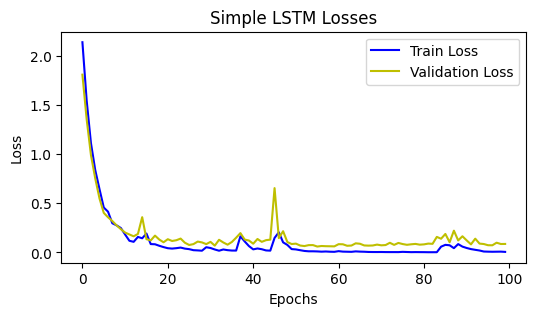

In [ ]:
#print losses and accuracies of LSTM1
_,(val_real_1,val_1)=eval(LSTM1,val_loader,criterion=crit)
_,(test_real_1,test_1)=eval(LSTM1,test_loader,criterion=crit)
acc_val_1=accuracy_score(np.concatenate(val_1),np.concatenate(val_real_1))
acc_test_1=accuracy_score(np.concatenate(test_1),np.concatenate(test_real_1))
print("Simple LSTM Accuracies: Validation Set: {} % -- Test Set: {} %".format(acc_val_1*100,acc_test_1*100))
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.plot(np.arange(epochs),train_arr_1,label='Train Loss',color='b')
plt.plot(np.arange(epochs),val_arr_1,label='Validation Loss',color='y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Simple LSTM Losses')
plt.show()

In [ ]:
#training and validation loss with dropout and wd
LSTM2 = BasicLSTM(input_dim=X_train[0].shape[1], rnn_size=128, output_dim=10, num_layers=1, bidirectional=False, bonus=False,dropout=0.2)
opt = torch.optim.Adam(LSTM2.parameters(), lr=0.001,weight_decay=1e-4) #l2 regulization
train_arr_2=[]
val_arr_2=[]
for i in range(epochs):
    temp_tr=train(LSTM2,train_loader,criterion=crit,optimizer=opt)
    temp_val=eval(LSTM2,val_loader,criterion=crit)
    val_arr_2.append(temp_val[0])
    train_arr_2.append(temp_tr)
    print("Epoch {}: Training Loss = {} Validation Loss = {}".format(i, temp_tr,temp_val[0]))
    torch.save(LSTM2, "./LSTM2") # checkpoint

C:\Users\manos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0: Training Loss = 2.1563189029693604 Validation Loss = 1.8512307405471802
Epoch 1: Training Loss = 1.599904081400703 Validation Loss = 1.43846861521403
Epoch 2: Training Loss = 1.1673469455803143 Validation Loss = 1.0118100974294875
Epoch 3: Training Loss = 0.9062735613654641 Validation Loss = 0.8228121995925903
Epoch 4: Training Loss = 0.6859385905896916 Validation Loss = 0.6394036213556925
Epoch 5: Training Loss = 0.5211278471876594 Validation Loss = 0.4656318459245894
Epoch 6: Training Loss = 0.3971153392511256 Validation Loss = 0.43159283532036674
Epoch 7: Training Loss = 0.3511219484841122 Validation Loss = 0.3117867327398724
Epoch 8: Training Loss = 0.26142503014382196 Validation Loss = 0.30654825932449764
Epoch 9: Training Loss = 0.20086404067628524 Validation Loss = 0.2177878345052401
Epoch 10: Training Loss = 0.17659158018582008 Validation Loss = 0.1954863741993904
Epoch 11: Training Loss = 0.13716504624223008 Validation Loss = 0.18759683519601822
Epoch 12: Training Los

Simple LSTM (with dropout and L2 reg.) Accuracies: Validation Set: 98.51851851851852 % -- Test Set: 98.33333333333333 %


Text(0.5, 1.0, 'Simple LSTM(with dropout and L2 reg.) Losses')

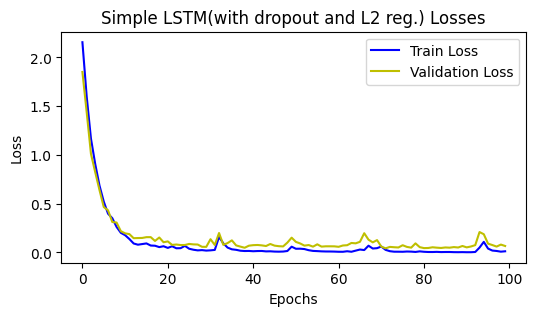

In [ ]:
#print losses and accuracies of LSTM2
_,(val_real_2,val_2)=eval(LSTM2,val_loader,criterion=crit)
_,(test_real_2,test_2)=eval(LSTM2,test_loader,criterion=crit)
acc_val_2=accuracy_score(np.concatenate(val_2),np.concatenate(val_real_2))
acc_test_2=accuracy_score(np.concatenate(test_2),np.concatenate(test_real_2))
print("Simple LSTM (with dropout and L2 reg.) Accuracies: Validation Set: {} % -- Test Set: {} %".format(acc_val_2*100,acc_test_2*100))
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.plot(np.arange(epochs),train_arr_2,label='Train Loss',color='b')
plt.plot(np.arange(epochs),val_arr_2,label='Validation Loss',color='y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Simple LSTM(with dropout and L2 reg.) Losses')

Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


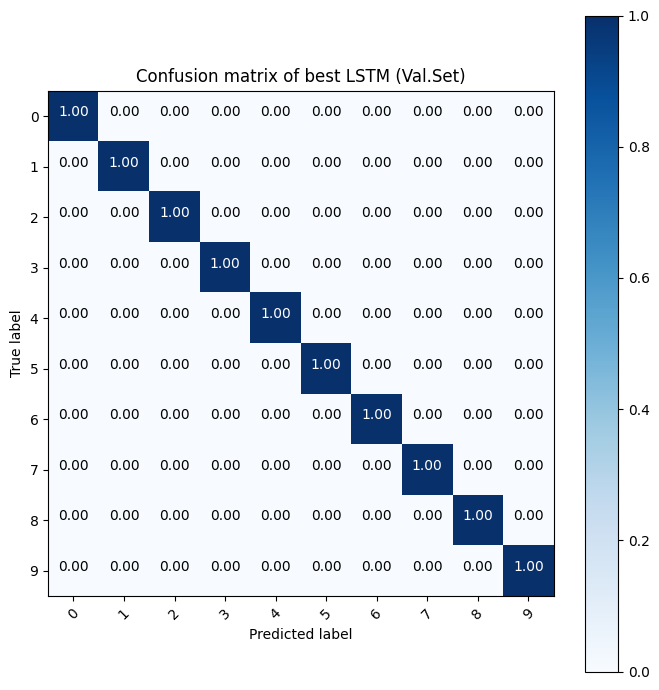

In [64]:
#plot confusion matrix for LSTM with best accuracy scores
best_lstm=torch.load("./LSTM2")
_,(val_real_best,val_best)=eval(best_lstm,val_loader,criterion=crit)
_,(test_real_best,test_best)=eval(best_lstm,test_loader,criterion=crit)

best_cm_val = np.zeros((10,10))
best_cm_test = np.zeros((10,10))

for sample in range(len(np.concatenate(val_best))):
    best_cm_val[np.concatenate(val_real_best)[sample], np.concatenate(val_best)[sample]] += 1

for sample in range(len(np.concatenate(test_best))):
    best_cm_test[np.concatenate(test_real_best)[sample], np.concatenate(test_best)[sample]] += 1

plot_confusion_matrix(best_cm_val, classes = [i for i in range(10)], normalize=True, title='Confusion matrix of best LSTM (Val.Set)', cmap=plt.cm.Blues)



Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.96666667 0.         0.
  0.03333333 0.         0.         0.        ]
 [0.         0.         0.         0.         0.96666667 0.03333333
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.03333333
  0.         0.96666667 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.03333333 0.         0.96666667 0.   

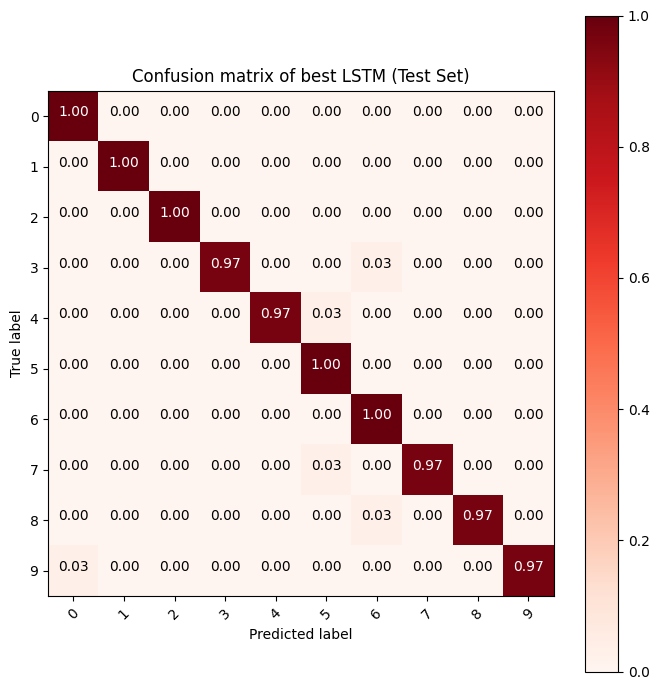

In [66]:
plot_confusion_matrix(best_cm_test, classes = [i for i in range(10)], normalize=True, title='Confusion matrix of best LSTM (Test Set)', cmap=plt.cm.Reds)

In [ ]:
#training and validation loss with dropout and wd and early stopping
LSTM3 = BasicLSTM(input_dim=X_train[0].shape[1], rnn_size=128, output_dim=10, num_layers=1, bidirectional=False, bonus=False,dropout=0.2)
opt = torch.optim.Adam(LSTM3.parameters(), lr=0.001,weight_decay=1e-4)
train_arr_3=[]
val_arr_3=[]
counter=0.0
min_loss=np.inf
for i in range(epochs):
    temp_tr=train(LSTM3,train_loader,criterion=crit,optimizer=opt)
    temp_val=eval(LSTM3,val_loader,criterion=crit)
    val_arr_3.append(temp_val[0])
    train_arr_3.append(temp_tr)
    print("Epoch {}: Training Loss = {} Validation Loss = {}".format(i, temp_tr,temp_val[0]))
    if (temp_val[0] < min_loss) :
        torch.save(LSTM3, "./LSTM3") # checkpoint
        min_loss = temp_val[0]
        counter = 0
    else:
        counter += 1
    
    if counter == 10:  # if it doesn't get any better, stop so as not to overfit
        print("Early Stopping")
        break

C:\Users\manos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0: Training Loss = 2.159704748321982 Validation Loss = 1.8578689363267686
Epoch 1: Training Loss = 1.545963911449208 Validation Loss = 1.3159522745344374
Epoch 2: Training Loss = 1.0597433868576498 Validation Loss = 0.8962968521647983
Epoch 3: Training Loss = 0.7397915843655082 Validation Loss = 0.6161203119489882
Epoch 4: Training Loss = 0.5385471792782054 Validation Loss = 0.47594088315963745
Epoch 5: Training Loss = 0.34729230885996537 Validation Loss = 0.40611691607369316
Epoch 6: Training Loss = 0.3312864040627199 Validation Loss = 0.3618306683169471
Epoch 7: Training Loss = 0.2551383702632259 Validation Loss = 0.5313326517740885
Epoch 8: Training Loss = 0.29476918367778554 Validation Loss = 0.228553906083107
Epoch 9: Training Loss = 0.1800966115997118 Validation Loss = 0.2299791028102239
Epoch 10: Training Loss = 0.16929458892520735 Validation Loss = 0.21166317330466378
Epoch 11: Training Loss = 0.12382720093078473 Validation Loss = 0.1540051649014155
Epoch 12: Training Los

LSTM with Early Stopping Accuracies: Validation Set: 96.29629629629629 % -- Test Set: 96.33333333333334 %


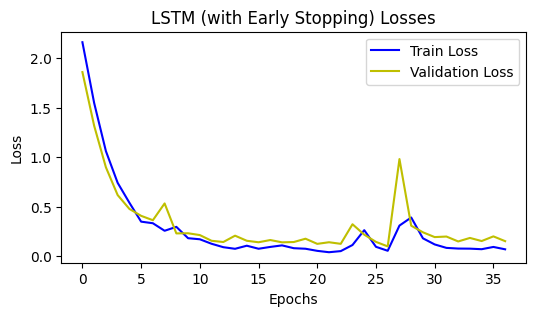

In [ ]:
#print losses and accuracies of LSTM3
_,(val_real_3,val_3)=eval(LSTM3,val_loader,criterion=crit)
_,(test_real_3,test_3)=eval(LSTM3,test_loader,criterion=crit)
acc_val_3=accuracy_score(np.concatenate(val_3),np.concatenate(val_real_3))
acc_test_3=accuracy_score(np.concatenate(test_3),np.concatenate(test_real_3))
print("LSTM with Early Stopping Accuracies: Validation Set: {} % -- Test Set: {} %".format(acc_val_3*100,acc_test_3*100))
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.plot(np.arange(np.shape(train_arr_3)[0]),train_arr_3,label='Train Loss',color='b')
plt.plot(np.arange(np.shape(val_arr_3)[0]),val_arr_3,label='Validation Loss',color='y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM (with Early Stopping) Losses')
plt.show()

In [ ]:
#training and validation loss with dropout and wd and early stopping and bd
LSTM4 = BasicLSTM(input_dim=X_train[0].shape[1], rnn_size=128, output_dim=10, num_layers=1, bidirectional=True, bonus=False,dropout=0.2)
opt = torch.optim.Adam(LSTM4.parameters(), lr=0.001,weight_decay=1e-4)
train_arr_4=[]
val_arr_4=[]
counter=0.0
min_loss=np.inf
for i in range(epochs):
    temp_tr=train(LSTM4,train_loader,criterion=crit,optimizer=opt)
    temp_val=eval(LSTM4,val_loader,criterion=crit)
    val_arr_4.append(temp_val[0])
    train_arr_4.append(temp_tr)
    print("Epoch {}: Training Loss = {} Validation Loss = {}".format(i, temp_tr,temp_val[0]))
    if (temp_val[0] < min_loss) :
        torch.save(LSTM4, "./LSTM4") # checkpoint
        min_loss = temp_val[0]
        counter = 0
    else:
        counter += 1
    
    if counter == 10:  # if it doesn't get any better, stop so as not to overfit
        print("Early Stopping")
        break

C:\Users\manos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0: Training Loss = 1.982924191390767 Validation Loss = 1.3738957643508911
Epoch 1: Training Loss = 0.8951644722153159 Validation Loss = 0.6340965694851346
Epoch 2: Training Loss = 0.45925672878237334 Validation Loss = 0.34736769729190403
Epoch 3: Training Loss = 0.3235928950940861 Validation Loss = 0.29571249584356946
Epoch 4: Training Loss = 0.23710684697417653 Validation Loss = 0.2250309396121237
Epoch 5: Training Loss = 0.1698239040287102 Validation Loss = 0.2023731710182296
Epoch 6: Training Loss = 0.13636473763514967 Validation Loss = 0.1714639729923672
Epoch 7: Training Loss = 0.11355396393029128 Validation Loss = 0.14928769858347046
Epoch 8: Training Loss = 0.09633057553540258 Validation Loss = 0.13106620353129175
Epoch 9: Training Loss = 0.08469448019476498 Validation Loss = 0.1896287211113506
Epoch 10: Training Loss = 0.09582930326680927 Validation Loss = 0.12492885688940684
Epoch 11: Training Loss = 0.07860972940483514 Validation Loss = 0.13327986540065873
Epoch 12: Tra

Bidirectional LSTM: Validation Set: 97.77777777777777 % -- Test Set: 97.33333333333334 %


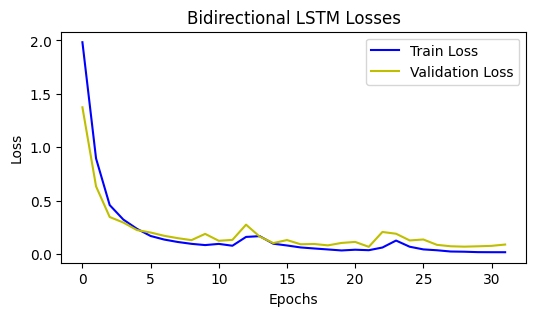

In [ ]:
#print losses and accuracies of LSTM4
_,(val_real_4,val_4)=eval(LSTM4,val_loader,criterion=crit)
_,(test_real_4,test_4)=eval(LSTM4,test_loader,criterion=crit)
acc_val_4=accuracy_score(np.concatenate(val_4),np.concatenate(val_real_4))
acc_test_4=accuracy_score(np.concatenate(test_4),np.concatenate(test_real_4))
print("Bidirectional LSTM: Validation Set: {} % -- Test Set: {} %".format(acc_val_4*100,acc_test_4*100))
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.plot(np.arange(np.shape(train_arr_4)[0]),train_arr_4,label='Train Loss',color='b')
plt.plot(np.arange(np.shape(val_arr_4)[0]),val_arr_4,label='Validation Loss',color='y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Bidirectional LSTM Losses')
plt.show()

In [ ]:
#training and validation loss with dropout and wd and early stopping and bd and bonus
# define a new training function
def train5(model, dataloader, criterion, optimizer):    
    tr_loss = 0.0
    model.train()   # train mode
    for i, batch in enumerate(dataloader, 1):
        inputs, labels, lengths = batch
        optimizer.zero_grad()   # zero gradients out
        y_preds,indices = model(inputs, lengths)    # forward propagate
        loss = criterion(y_preds, labels[indices])   # compute loss function
        loss.backward() # compute gradients
        optimizer.step()    # update parameters

        tr_loss += loss.data.item()

    return tr_loss/i   # train loss


# neural network evaluator
def eval5(model, dataloader, criterion):
    val_loss = 0.0
    y_act = []
    y_pred = []
    
    model.eval() # evaluation mode
    with torch.no_grad(): # do not compute gradients
        for i, batch in enumerate(dataloader, 1):
            
            inputs, labels, lengths = batch
                
            y_preds,indices = model(inputs, lengths) #forward propagate
            loss = criterion(y_preds, labels[indices]) #loss function
            pred = torch.argmax(y_preds, dim=1) #make predictions
            
            y_pred.append(pred.numpy()) #get predicted labels
            y_act.append(labels.numpy()) #get real lables

            val_loss += loss.data.item() #add to validation loss

    return val_loss / i, (y_act, y_pred)

# neural network evaluator
def eval(model, dataloader, criterion):
    val_loss = 0.0
    y_act = []
    y_pred = []
    
    model.eval() # evaluation mode
    with torch.no_grad(): # do not compute gradients
        for i, batch in enumerate(dataloader, 1):
            
            inputs, labels, lengths = batch
                
            y_preds = model(inputs, lengths) #forward propagate
            loss = criterion(y_preds, labels) #loss function
            pred = torch.argmax(y_preds, dim=1) #make predictions
            
            y_pred.append(pred.numpy()) #get predicted labels
            y_act.append(labels.numpy()) #get real lables

            val_loss += loss.data.item() #add to validation loss

    return val_loss / i, (y_act, y_pred)



LSTM5 = BasicLSTM(input_dim=X_train[0].shape[1], rnn_size=128, output_dim=10, num_layers=1, bidirectional=True, bonus=True,dropout=0.2)
opt = torch.optim.Adam(LSTM5.parameters(), lr=0.001,weight_decay=1e-4)
train_arr_5=[]
val_arr_5=[]
counter=0.0
min_loss=np.inf
for i in range(epochs):
    temp_tr=train5(LSTM5,train_loader,criterion=crit,optimizer=opt)
    temp_val=eval5(LSTM5,val_loader,criterion=crit)
    val_arr_5.append(temp_val[0])
    train_arr_5.append(temp_tr)
    print("Epoch {}: Training Loss = {} Validation Loss = {}".format(i, temp_tr,temp_val[0]))
    if (temp_val[0] < min_loss) :
        torch.save(LSTM5, "./LSTM5") # checkpoint
        min_loss = temp_val[0]
        counter = 0
    else:
        counter += 1
    
    if counter == 10:  # if it doesn't get any better, stop so as not to overfit
        print("Early Stopping")
        break

C:\Users\manos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0: Training Loss = 2.106924132064537 Validation Loss = 1.6296823876244682
Epoch 1: Training Loss = 1.181925098101298 Validation Loss = 0.821163935320718
Epoch 2: Training Loss = 0.6202194966651775 Validation Loss = 0.45502167088644846
Epoch 3: Training Loss = 0.39006338516871136 Validation Loss = 0.3535346942288535
Epoch 4: Training Loss = 0.3048901977362456 Validation Loss = 0.33130162954330444
Epoch 5: Training Loss = 0.23246627935656794 Validation Loss = 0.19794766817774093
Epoch 6: Training Loss = 0.16102977317792397 Validation Loss = 0.18513640122754232
Epoch 7: Training Loss = 0.1209666246065387 Validation Loss = 0.12796034876789367
Epoch 8: Training Loss = 0.10680260798997349 Validation Loss = 0.12853662243911199
Epoch 9: Training Loss = 0.0880890912203877 Validation Loss = 0.12495782226324081
Epoch 10: Training Loss = 0.08617082210602584 Validation Loss = 0.12182713725737163
Epoch 11: Training Loss = 0.08728746117817031 Validation Loss = 0.1274934017232486
Epoch 12: Train

LSTM with pack_padded_sequence: Validation Set: 9.953703703703704 % -- Test Set: 10.666666666666668 %


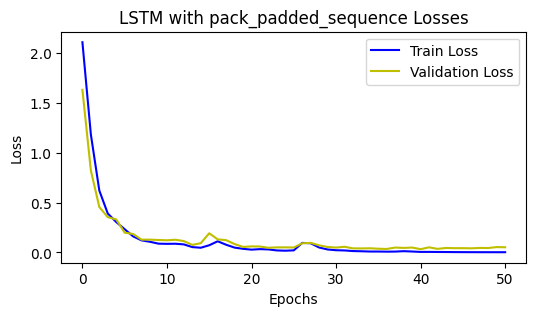

In [ ]:
#print losses and accuracies of LSTM5
_,(val_real_5,val_5)=eval5(LSTM5,val_loader,criterion=crit)
_,(test_real_5,test_5)=eval5(LSTM5,test_loader,criterion=crit)
acc_val_5=accuracy_score(np.concatenate(val_5),np.concatenate(val_real_5))
acc_test_5=accuracy_score(np.concatenate(test_5),np.concatenate(test_real_5))
print("LSTM with pack_padded_sequence: Validation Set: {} % -- Test Set: {} %".format(acc_val_5*100,acc_test_5*100))
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.plot(np.arange(np.shape(train_arr_5)[0]),train_arr_5,label='Train Loss',color='b')
plt.plot(np.arange(np.shape(val_arr_5)[0]),val_arr_5,label='Validation Loss',color='y')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM with pack_padded_sequence Losses')
plt.legend()
plt.show()